In [107]:
##################----------------- Import Libraries -------------########################

from pyomo.environ import *
from pyomo.opt import SolverFactory
import math
import os
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.pf as pf
from pandapower import networks
import pandapower.plotting as plot
import pandapower.networks as pn
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import t
import sys
current_directory = os.getcwd()

In [108]:
# For auto reload libraries without the need to restart kernel
############# USE ONLY IN DEVELOPING MODE FOR EASIER MODIFICAITON IN LIBRARIES ##############3
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
%run ../Data/networks/three_feeders_Strovolides_Network.ipynb

#######################------------------- Easy method to get the admittance Matrix ----------------####################33
# Run a power flow calculation

pp.runpp(net)

# Access the Y-bus matrix from the network results
Ybus = net["_ppc"]["internal"]["Ybus"]
# print("Y-bus matrix:\n", Ybus.todense())

# Convert the sparse Y-bus matrix to a dense format and then to a DataFrame
Y_bus_df = pd.DataFrame(Ybus.todense())

# Add row and column labels if needed
Y_bus_df.index = net.bus.index
Y_bus_df.columns = net.bus.index

# print(Y_bus_df)

### Generate load/DER time scale data
file_path2 = '../Data/profiles/pv_load_profiles/Profiles_for_testing.xlsx'
profiles = pd.read_excel(file_path2)
profiles = pd.concat([profiles]*2, ignore_index=True)

In [110]:
############## Initialize model ######################
# model = ConcreteModel() # Create the pyomo model
# import suffixes (marginal values) -- "import them from the solver"
# model.dual = Suffix(direction=Suffix.IMPORT) #This save the dual variables and give us information about how the constrains affect the solution
sys.path.append('../v8_Main/src')

from Manager import *
manager = Manager(net=net)
manager.addTime(timeframe=48,time_interval=30) ## At objective, timeframe(in hours) , time-interval(in minutes)

# During the Manager call there was pyomo creation model and several other initializations that automatically transfer the pandapower
# probelm into a dataframe for easily access on them after.
# The major procedure was made in AdditionalData Class which is located for now and then in .anc_Vars.

print(manager.net) # This is the pandapower details it was extremely important since most of the parameters are based on this
print(f"f={manager.anc_Vars.f:.4f}, S_Base={manager.anc_Vars.S_Base:.4f}, V_Base={manager.anc_Vars.V_Base:.4f}, Z_base={manager.anc_Vars.Z_base:.4f}, I_base={manager.anc_Vars.I_base:.4f}")
###### Everything was in p.u. ######
print(manager.anc_Vars.System_Data_Nodes, "\n", manager.anc_Vars.System_Data_Lines, "\n", manager.anc_Vars.System_Data_DER, "\n", "\n", manager.anc_Vars.System_Data_Grid, "\n", manager.anc_Vars.system_data_load)
##### If some of the DER is controllable you have to defined it manually since pandapower does not have this function. #####
manager.anc_Vars.System_Data_DER.loc[0,'Controllable']=True

# Currently the following lists is empty however during the run you can access and see the available set,variables, 
# parameters and constraints through this code.
print(manager.list_variables())
print(manager.list_parameters())
print(manager.list_constraints())
print(manager.list_sets())


This pandapower network includes the following parameter tables:
   - bus (62 elements)
   - load (61 elements)
   - sgen (22 elements)
   - ext_grid (1 element)
   - line (61 elements)
 and the following results tables:
   - res_bus (62 elements)
   - res_line (61 elements)
   - res_ext_grid (1 element)
   - res_load (61 elements)
   - res_sgen (22 elements)
f=50.0000, S_Base=0.3150, V_Base=0.4000, Z_base=0.5079, I_base=0.4547
    Nodes  min_v  max_v Feeder
0       0   0.95   1.05   None
1       1   0.95   1.05     F1
2       2   0.95   1.05     F1
3       3   0.95   1.05     F1
4       4   0.95   1.05     F1
5       5   0.95   1.05     F1
6       6   0.95   1.05     F1
7       7   0.95   1.05     F1
8       8   0.95   1.05     F1
9       9   0.95   1.05     F1
10     10   0.95   1.05     F1
11     11   0.95   1.05     F1
12     12   0.95   1.05     F1
13     13   0.95   1.05     F1
14     14   0.95   1.05     F1
15     15   0.95   1.05     F1
16     16   0.95   1.05     F1
17     17 

In [111]:
# Custom Add EVs since in pandapower EVs are not available

manager.anc_Vars.addEV(node=1,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
manager.anc_Vars.addEV(node=3,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
manager.anc_Vars.addEV(node=5,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])
manager.anc_Vars.addEV(node=7,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[31,31+48],departure=[13,13+48],distance=[1,1])
manager.anc_Vars.addEV(node=9,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=19,arrival=[32,32+48],departure=[10,10+48],distance=[140,140])
manager.anc_Vars.addEV(node=11,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=80, EV_cons=18,arrival=[40,40+48],departure=[35,35+48],distance=[5,5])
manager.anc_Vars.addEV(node=13,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[37,37+48],departure=[17,17+48],distance=[200,200])
manager.anc_Vars.addEV(node=15,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=19,arrival=[36,36+48],departure=[11,11+48],distance=[10,10])
manager.anc_Vars.addEV(node=17,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=19,arrival=[30,30+48],departure=[16,16+48],distance=[10,10])
manager.anc_Vars.addEV(node=19,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[37,37+48],departure=[13,13+48],distance=[2,2])

manager.anc_Vars.addEV(node=25,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=60, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[26,26+48],departure=[15,15+48],distance=[150,150])
manager.anc_Vars.addEV(node=27,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=15,arrival=[32,32+48],departure=[14,14+48],distance=[160,160])
manager.anc_Vars.addEV(node=29,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[36,36+48],departure=[13,13+48],distance=[5,5])
manager.anc_Vars.addEV(node=31,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=16, EV_SoC_max=100, EV_cons=15, arrival=[32,32+48],departure=[14,14+48],distance=[135,135])
manager.anc_Vars.addEV(node=32,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[11,11+48],distance=[1,1])

manager.anc_Vars.addEV(node=33,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=60, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[30,30+48],departure=[13,13+48],distance=[5,5])
manager.anc_Vars.addEV(node=35,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=16,arrival=[35,35+48],departure=[11,11+48],distance=[1,1])
manager.anc_Vars.addEV(node=37,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=18,arrival=[30,30+48],departure=[14,14+48],distance=[30,30])
manager.anc_Vars.addEV(node=39,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=20, EV_SoC_max=100, EV_cons=17,arrival=[39,39+48],departure=[14,14+48],distance=[140,140])
manager.anc_Vars.addEV(node=41,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=45, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=100, EV_cons=19,arrival=[34,34+48],departure=[11,11+48],distance=[35,35])
manager.anc_Vars.addEV(node=43,P_min_ch=0, P_max_ch=11, Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=40, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=100, EV_cons=18,arrival=[24,24+48],departure=[14,14+48],distance=[45,45])

print(manager.anc_Vars.system_data_ev)
print(manager.anc_Vars.system_data_ev_char)


    EV_node  EV_Pmin_ch  EV_Pmax_ch   EV_Qmin   EV_Qmax     P_control  \
0         1         0.0    0.034921 -0.011479  0.011479  controllable   
1         3         0.0    0.034921 -0.011479  0.011479  controllable   
2         5         0.0    0.034921 -0.011479  0.011479  controllable   
3         7         0.0    0.034921 -0.011479  0.011479  controllable   
4         9         0.0    0.034921 -0.011479  0.011479  controllable   
5        11         0.0    0.034921 -0.011479  0.011479  controllable   
6        13         0.0    0.034921 -0.011479  0.011479  controllable   
7        15         0.0    0.034921 -0.011479  0.011479  controllable   
8        17         0.0    0.034921 -0.011479  0.011479  controllable   
9        19         0.0    0.034921 -0.011479  0.011479  controllable   
10       25         0.0    0.034921 -0.011479  0.011479  controllable   
11       27         0.0    0.034921 -0.011479  0.011479  controllable   
12       29         0.0    0.034921 -0.011479  0.01

In [112]:
# This code initialize/create all the needed sets in pyomo model.
manager.initialize_sets()  # Initialize sets

print(manager.list_sets())
manager.show_set("Sbuses")
manager.show_set("SGenbuses")
manager.show_set("SGrid")
manager.show_set("SDER_contr")
manager.show_set("SDER_uncontr")
manager.show_set("SLoadbuses")
manager.show_set("Slines")
manager.show_set("STimes")
manager.show_set("SEVbuses")
manager.show_set("SDistance_ind")

['Sbuses', 'SGrid', 'SDER_contr', 'SDER_uncontr', 'SLoadbuses', 'Slines', 'STimes', 'SEVbuses', 'SDistance_ind']
Set Sbuses: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
Set 'SGenbuses' does not exist.
Set SGrid: [0]
Set SDER_contr: [1]
Set SDER_uncontr: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 32, 33, 35, 37, 39, 40]
Set SLoadbuses: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
Set Slines: [(0, 1), (0, 25), (0, 33), (1, 2), (2, 3), (3, 4), (4, 5), (2, 6), (6, 7), (7, 8), (1, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (12, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 2

In [113]:
############################---------------------- Define Parameters ---------------------############################

# Why defined parameters? if we defined parameters instead of using for example panda dataframe then we can rerun the model without the need to 
# rebuild the constraints during the solving it automatically get the new parameters so the steps for a load modification example is the following
# 1) Define the load profile dataframe, 2) Run variables 3) Run parameters, 4)Build model, 5) Solve optimization, 6)Change load profile , 7) Run parameters ,8) Solve optimization
# MUTABLE=TRUE is the function parameter that allow this

manager.load_profile_param(profiles, "Load_P", "Load_Q") # This create Load_P and Load_Q profile which is equal to PandapowerPower*p.u. [from profiles files]
manager.line_param(Y_bus_df, "resistance_Parm", "admitt_mat_Parm_real", "admitt_mat_Parm_imag")

############ EV #################
manager.initialize_ev_params("ev_min_ch_param", "ev_max_ch_param", "EVinit_SOC", "EVend_SOC_param", "EV_SoC_min_param", "EV_SoC_max_param", "EV_capacity_param")
manager.initialize_ev_char_params("ev_arrival_time_param", "ev_departure_time_param", "ev_trip_distance_param", "EV_SoC_min_departure_param",  "EV_trip_energy_needs_param", "EV_available_param" )
manager.initialize_ev_min_soc_timeseries("EV_SoC_min_overtime_param")

############ DER #################
manager.der_profile_param(profiles, "unctrl_PV_gen_P", "unctrl_PV_gen_Q", "ctrl_PV_gen_P", "ctrl_PV_gen_Q")

print(manager.list_parameters())
manager.show_parameter("Load_P")

['Load_P', 'Load_Q', 'resistance_Parm', 'admitt_mat_Parm_real', 'admitt_mat_Parm_imag', 'ev_min_ch_param', 'ev_max_ch_param', 'EVinit_SOC', 'EVend_SOC_param', 'EV_SoC_min_param', 'EV_SoC_max_param', 'EV_capacity_param', 'ev_arrival_time_param', 'ev_departure_time_param', 'ev_trip_distance_param', 'EV_SoC_min_departure_param', 'EV_trip_energy_needs_param', 'EV_available_param', 'EV_SoC_min_overtime_param', 'unctrl_PV_gen_P', 'ctrl_PV_gen_P', 'unctrl_PV_gen_Q', 'ctrl_PV_gen_Q']
Variable Load_P:
  (1, 0): 0.007778337437460318
  (1, 1): 0.007548256571428571
  (1, 2): 0.007402299058412698
  (1, 3): 0.007253581271746031
  (1, 4): 0.007061102495238095
  (1, 5): 0.006771032133333334
  (1, 6): 0.0064615987580952374
  (1, 7): 0.006213990239365078
  (1, 8): 0.005917003424126984
  (1, 9): 0.005540396665396825
  (1, 10): 0.005515541570793651
  (1, 11): 0.005258671019047618
  (1, 12): 0.005241968411428571
  (1, 13): 0.005341841427301586
  (1, 14): 0.005375855011428571
  (1, 15): 0.005586753538412698

In [114]:
############################---------------------- Define Variables ---------------------############################

# In this test case as most of the functions will be used. Therefore both downward and upward and operation scenarios are modeled. 

###################### Downward Activation Scenario ########################
manager.initialize_voltage_variables("v_d", "pa_d")
manager.initialize_power_variable("pgrid_d", manager.model.SGrid)
manager.initialize_power_variable("qgrid_d", manager.model.SGrid)
manager.initialize_power_variable("sgrid_d", manager.model.SGrid)
manager.initialize_der_variables("pder_contr_d", "pder_curtail_contr_d", "qder_contr_d")
manager.initialize_line_variables("Line_curr_d", "Line_rea_curr_d", "Line_act_curr_d", "Line_losses_d")

###################### Upward Activation Scenario ########################
manager.initialize_voltage_variables("v_u", "pa_u")
manager.initialize_power_variable("pgrid_u", manager.model.SGrid)
manager.initialize_power_variable("qgrid_u", manager.model.SGrid)
manager.initialize_power_variable("sgrid_u", manager.model.SGrid)
manager.initialize_der_variables("pder_contr_u", "pder_curtail_contr_u", "qder_contr_u")
manager.initialize_line_variables("Line_curr_u", "Line_rea_curr_u", "Line_act_curr_u", "Line_losses_u")


# ###################### Normal Operation Scenario ########################
manager.initialize_voltage_variables("v", "pa")
manager.initialize_power_variable("pgrid", manager.model.SGrid)
manager.initialize_power_variable("qgrid", manager.model.SGrid)
manager.initialize_power_variable("sgrid", manager.model.SGrid)
manager.initialize_der_variables("pder_contr", "pder_curtail_contr", "qder_contr")
manager.initialize_line_variables("Line_curr", "Line_rea_curr", "Line_act_curr", "Line_losses")

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v_d[ref_bus, t].fix(1)
    manager.model.pa_d[ref_bus, t].fix(0)

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v_u[ref_bus, t].fix(1)
    manager.model.pa_u[ref_bus, t].fix(0)

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v[ref_bus, t].fix(1)
    manager.model.pa[ref_bus, t].fix(0)

###################### EV Variables ########################

manager.initialize_ev_variables("pEVch","qEV", "EVsoc")
manager.initialize_ev_flexibility_variables("ev_ch_dp" , "pup_flex_ev", "pdown_flex_ev")

print(manager.list_variables())

['v_d', 'pa_d', 'pgrid_d', 'qgrid_d', 'sgrid_d', 'pder_contr_d', 'pder_curtail_contr_d', 'qder_contr_d', 'Line_curr_d', 'Line_rea_curr_d', 'Line_act_curr_d', 'Line_losses_d', 'v_u', 'pa_u', 'pgrid_u', 'qgrid_u', 'sgrid_u', 'pder_contr_u', 'pder_curtail_contr_u', 'qder_contr_u', 'Line_curr_u', 'Line_rea_curr_u', 'Line_act_curr_u', 'Line_losses_u', 'v', 'pa', 'pgrid', 'qgrid', 'sgrid', 'pder_contr', 'pder_curtail_contr', 'qder_contr', 'Line_curr', 'Line_rea_curr', 'Line_act_curr', 'Line_losses', 'pEVch', 'qEV', 'EVsoc', 'ev_ch_dp', 'pup_flex_ev', 'pdown_flex_ev']


In [115]:
########### Line Flow constraints ########################
manager.add_real_line_flow_constraint("real_line_up_flow", manager.model.Line_act_curr_u, manager.model.v_u, manager.model.pa_u)
manager.add_reactive_line_flow_constraint("reactive_line_up_flow", manager.model.Line_rea_curr_u, manager.model.v_u, manager.model.pa_u)
manager.add_line_flow_constraint("line_flow_up", manager.model.Line_curr_u, manager.model.Line_act_curr_u, manager.model.Line_rea_curr_u)

manager.add_real_line_flow_constraint("real_line_down_flow", manager.model.Line_act_curr_d, manager.model.v_d, manager.model.pa_d)
manager.add_reactive_line_flow_constraint("reactive_line_down_flow", manager.model.Line_rea_curr_d, manager.model.v_d, manager.model.pa_d)
manager.add_line_flow_constraint("line_flow_down", manager.model.Line_curr_d, manager.model.Line_act_curr_d, manager.model.Line_rea_curr_d)

manager.add_real_line_flow_constraint("real_line_flow", manager.model.Line_act_curr, manager.model.v, manager.model.pa)
manager.add_reactive_line_flow_constraint("reactive_line_flow", manager.model.Line_rea_curr, manager.model.v, manager.model.pa)
manager.add_line_flow_constraint("line_flow", manager.model.Line_curr, manager.model.Line_act_curr, manager.model.Line_rea_curr)
manager.add_line_flow_losses_constraint(manager.model.Line_curr,  "line_losses")

# manager.add_amplitude_constraint_rule(manager.model.pgrid_u,manager.model.qgrid_u,manager.model.sgrid_u, "grid_apparent_u")
# manager.add_amplitude_constraint_rule(manager.model.pgrid_d,manager.model.qgrid_d,manager.model.sgrid_d, "grid_apparent_d")
# manager.add_amplitude_constraint_rule(manager.model.pgrid,manager.model.qgrid,manager.model.sgrid, "grid_apparent")

###################-----------------Curtail DER Power Constrain ------------#######################
def Curtail_DER_Power_rule_up(model, i, time):
    return (model.pder_curtail_contr_u[i,time] ==  model.pder_curtail_contr_u[i,  time].ub - model.pder_contr_u[i,  time])
manager.model.Curtail_DER_cons_up = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule_up)  # Minimum, Maximum power for Gen

def Curtail_DER_Power_rule_down(model, i, time):
    return (model.pder_curtail_contr_d[i,time] ==  model.pder_curtail_contr_d[i,  time].ub - model.pder_contr_d[i,  time])
manager.model.Curtail_DER_cons_down = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule_down)  # Minimum, Maximum power for Gen

def Curtail_DER_Power_rule(model, i, time):
    return (model.pder_curtail_contr[i,time] ==  model.pder_curtail_contr[i,  time].ub - model.pder_contr[i,  time])
manager.model.Curtail_DER_cons = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule)  # Minimum, Maximum power for Gen


In [116]:
####################-------------------- EV Constrain -----------------------#######################
manager.add_ev_soc_constraint("EV_SOC_cons")
manager.add_power_ch_dp_ev_cons("power_ch_dp_ev_cons")

# #################### EV minimum SoC before departure ################ 
manager.add_ev_min_departure_soc_constraint("EV_min_departure_SOC_cons")

# Fix variables for non-charging times
manager.fix_ev_non_charging_times(manager.model.pEVch, manager.model.pup_flex_ev, manager.model.pdown_flex_ev)

# ###################### Upward Flexibility Constraints ########################
manager.add_power_up_flex_ev_cons("power_up_flex_ev_cons")
manager.add_power_up_flex_max_cons("power_up_max_cons")

# ###################### Downward Flexibility Constraints ########################
manager.add_power_down_flex_min_cons("power_down_flex_ev_cons")
manager.add_power_down_flex_ev_cons("power_down_min_cons")

In [117]:
manager.add_active_power_flex_flow_constraint(manager.model.pder_contr_u, manager.model.pgrid_u, manager.model.pEVch, manager.model.pup_flex_ev, manager.model.v_u, manager.model.pa_u, "active_power_up_flow", "upward")
manager.add_reactive_power_flex_flow_constraint(manager.model.qder_contr_u, manager.model.qgrid_u, manager.model.qEV, manager.model.v_u, manager.model.pa_u, "reactive_power_up_flow")

manager.add_active_power_flex_flow_constraint(manager.model.pder_contr_d, manager.model.pgrid_d, manager.model.pEVch, manager.model.pdown_flex_ev, manager.model.v_d, manager.model.pa_d, "active_power_down_flow", "downward")
manager.add_reactive_power_flex_flow_constraint(manager.model.qder_contr_d, manager.model.qgrid_d, manager.model.qEV, manager.model.v_d, manager.model.pa_d, "reactive_power_down_flow")

manager.add_active_power_flow_constraint(manager.model.pder_contr, manager.model.pgrid, manager.model.pEVch, manager.model.v, manager.model.pa, "active_power_flow")
manager.add_reactive_power_flow_constraint(manager.model.qder_contr, manager.model.qgrid, manager.model.qEV, manager.model.v, manager.model.pa, "reactive_power_flow")


In [118]:
#objective function
def obj_rule(model,k):
    return (0
            - sum(model.pup_flex_ev[k, time] for time in model.STimes for k in model.SEVbuses) # This can be removed and just at down limit
            - sum(model.pdown_flex_ev[k, time] for time in model.STimes for k in model.SEVbuses) # This can be removed and just at down limit
            )
manager.model.obj = Objective(rule=obj_rule, sense=minimize)


In [119]:
# Define the solver without syntax issues and include line breaks
solver = SolverFactory('ipopt')

solver.options['max_iter'] = 5000  # Increase the maximum number of iterations
solver.options['tol'] = 1e-10       # Set a smaller tolerance for convergence
solver.options['print_level'] = 5  # Higher levels provide more detailed output (0-12)
# solver.options['acceptable_tol'] = 1e-4            # early stopping
# solver.options['output_file'] = 'ipopt_log.txt'  # Save IPOPT log to a file

results = solver.solve(manager.model, tee=True)

# After solving, print the results
print("Status: ", results.solver.status)
print("Termination Condition: ", results.solver.termination_condition)

# Check if the solution is feasible
if results.solver.termination_condition == TerminationCondition.optimal:
    
    print("successful")
    # Extract solver timing (wallclock time)
    solver_time = results.solver.time  # Total solving time in seconds
    print(f"Solver Time: {solver_time} seconds")

else:
    print("Infeasible solution.")

Ipopt 3.14.17: max_iter=5000
tol=1e-10
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   467446
Number of nonzeros in inequality constraint Jacobian.:    15670
Number of nonzeros in Lagrangian Hessian.............:   172224

Total number of variables............................:   104808
                     variables with only lower bounds:     8272
                variables with lower and upper bounds:    58808
                     variables with only upper bounds:        0
Total number of equality constraints..

In [120]:
manager.results.wrapper_var_results()
print(manager.results.list())
print(manager.results.EVsoc.head())

['EVsoc', 'Line_act_curr', 'Line_act_curr_d', 'Line_act_curr_u', 'Line_curr', 'Line_curr_d', 'Line_curr_u', 'Line_losses', 'Line_losses_d', 'Line_losses_u', 'Line_rea_curr', 'Line_rea_curr_d', 'Line_rea_curr_u', 'ev_ch_dp', 'pEVch', 'pa', 'pa_d', 'pa_u', 'pder_contr', 'pder_contr_d', 'pder_contr_u', 'pder_curtail_contr', 'pder_curtail_contr_d', 'pder_curtail_contr_u', 'pdown_flex_ev', 'pgrid', 'pgrid_d', 'pgrid_u', 'pup_flex_ev', 'qEV', 'qder_contr', 'qder_contr_d', 'qder_contr_u', 'qgrid', 'qgrid_d', 'qgrid_u', 'sgrid', 'sgrid_d', 'sgrid_u', 'v', 'v_d', 'v_u']
          1         3         5         7         9        11        13  \
0  0.067737  0.098596  0.089665  0.101667  0.086814  0.089260  0.103684   
1  0.081120  0.099419  0.090433  0.102001  0.093145  0.089632  0.106037   
2  0.093698  0.100247  0.091193  0.102335  0.099138  0.090003  0.108389   
3  0.093698  0.101082  0.091947  0.102669  0.104968  0.090375  0.110755   
4  0.093698  0.101925  0.092695  0.103003  0.110681  0.09

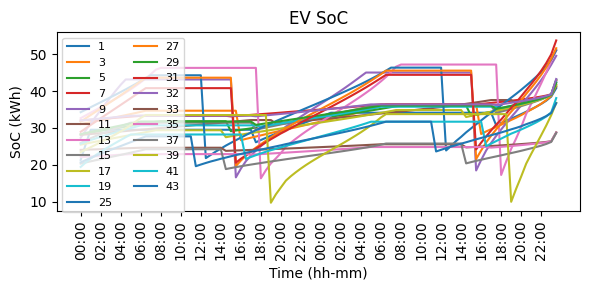

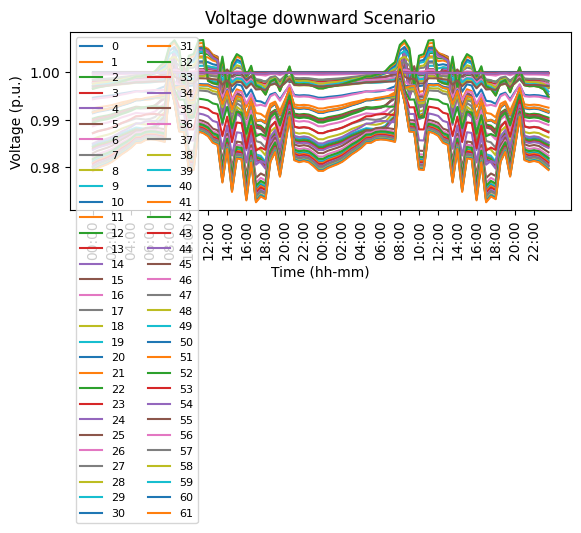

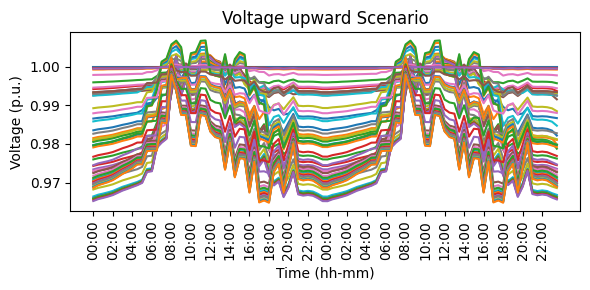

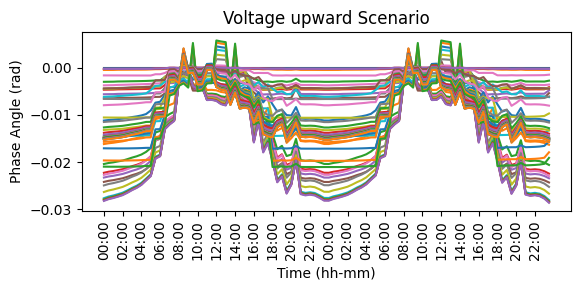

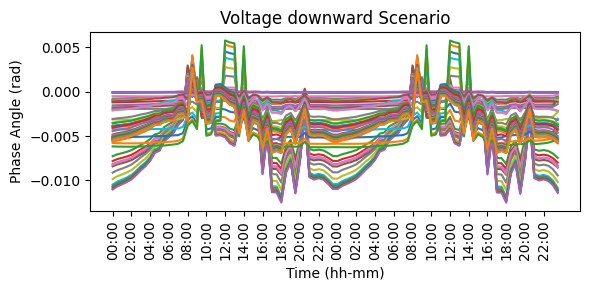

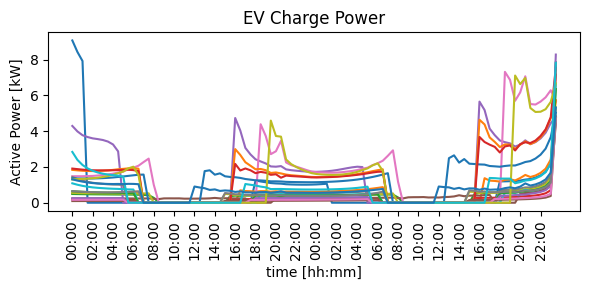

In [121]:
manager.plot_fun.result_df_plot(manager.results.EVsoc*manager.anc_Vars.S_Base*1000,"EV SoC", "Time (hh-mm)" ,"SoC (kWh)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.v_d,"Voltage downward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")
manager.plot_fun.result_df_plot(manager.results.v_u,"Voltage upward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)")
manager.plot_fun.result_df_plot(manager.results.pa_u,"Voltage upward Scenario", "Time (hh-mm)" ,"Phase Angle (rad)")
manager.plot_fun.result_df_plot(manager.results.pa_d,"Voltage downward Scenario", "Time (hh-mm)" ,"Phase Angle (rad)")
manager.plot_fun.result_df_plot(manager.results.pEVch*manager.anc_Vars.S_Base*1000,"EV Charge Power", "time [hh:mm]" ,"Active Power [kW]")



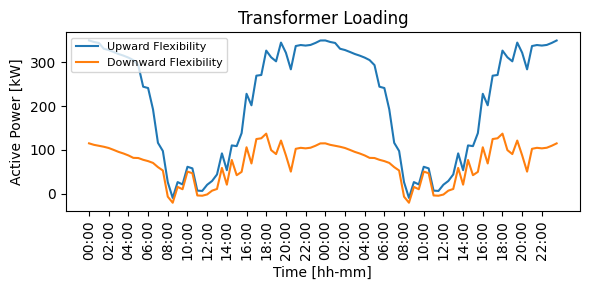

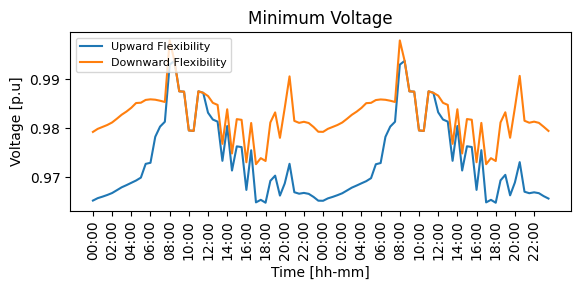

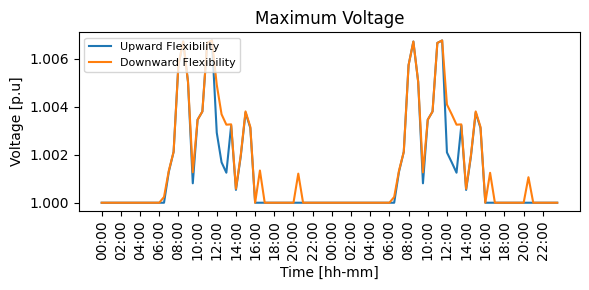

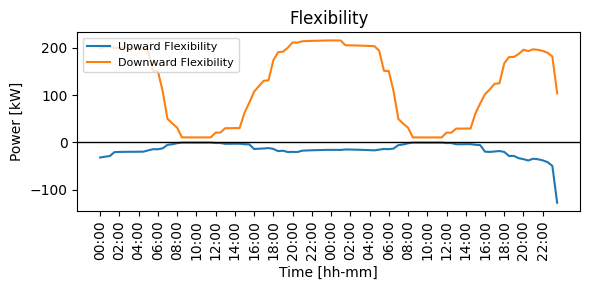

In [122]:
manager.results_flexibility_plot(manager.results.pgrid_u*manager.anc_Vars.S_Base*1000,manager.results.pgrid_d*manager.anc_Vars.S_Base*1000,"Transformer Loading", "Time [hh-mm]", "Active Power [kW]")
manager.results_flexibility_plot(manager.results.v_u.min(axis=1),manager.results.v_d.min(axis=1),"Minimum Voltage", "Time [hh-mm]", "Voltage [p.u]")
manager.results_flexibility_plot(manager.results.v_u.max(axis=1),manager.results.v_d.max(axis=1),"Maximum Voltage", "Time [hh-mm]", "Voltage [p.u]")
manager.results_flexibility_plot(manager.results.pdown_flex_ev.sum(axis=1)*manager.anc_Vars.S_Base*-1000,manager.results.pup_flex_ev.sum(axis=1)*manager.anc_Vars.S_Base*1000,"Flexibility", "Time [hh-mm]", "Power [kW]", zero_axes="yes", shading="Yes")


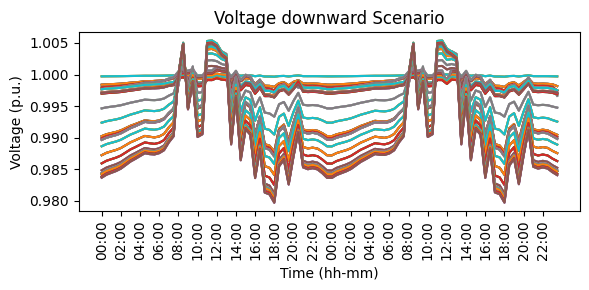

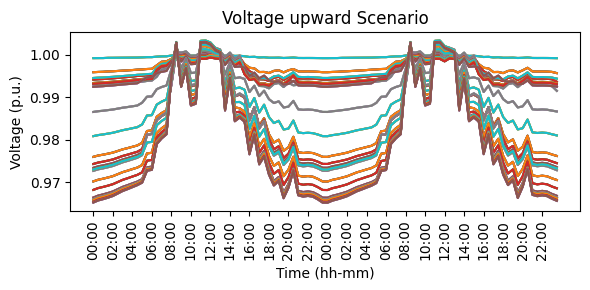

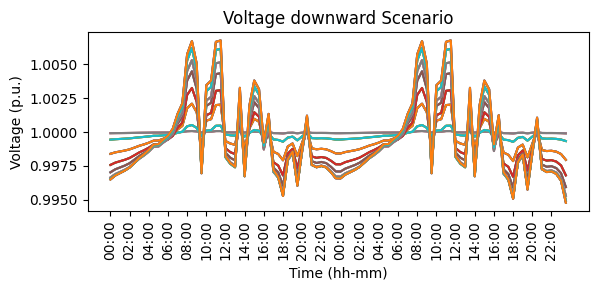

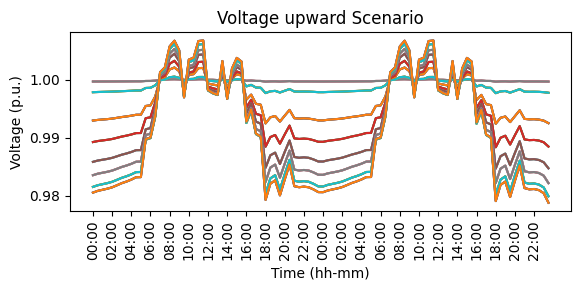

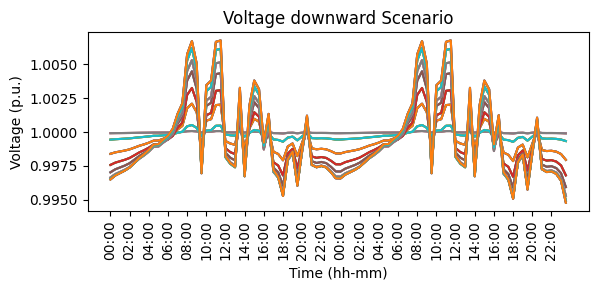

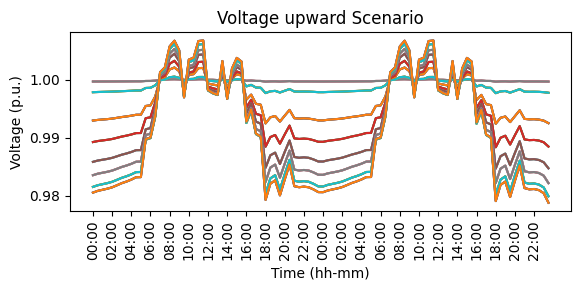

In [125]:
feeder1_buses=list(Feeder1.values())+list(Feeder1.values())
feeder1_buses = [str(bus) for bus in feeder1_buses]

feeder2_buses=list(Feeder2.values())+list(Feeder2.values())
feeder2_buses = [str(bus) for bus in feeder2_buses]

feeder3_buses=list(Feeder3.values())+list(Feeder3.values())
feeder3_buses = [str(bus) for bus in feeder2_buses]

manager.plot_fun.result_df_plot(manager.results.v_d[feeder1_buses],"Voltage downward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)")
manager.plot_fun.result_df_plot(manager.results.v_u[feeder1_buses],"Voltage upward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)")
manager.plot_fun.result_df_plot(manager.results.v_d[feeder2_buses],"Voltage downward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)")
manager.plot_fun.result_df_plot(manager.results.v_u[feeder2_buses],"Voltage upward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)")
manager.plot_fun.result_df_plot(manager.results.v_d[feeder3_buses],"Voltage downward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)")
manager.plot_fun.result_df_plot(manager.results.v_u[feeder3_buses],"Voltage upward Scenario", "Time (hh-mm)" ,"Voltage (p.u.)")



In [124]:
# ########## Export transformer data for paper plot ############

# # Assuming these are your DataFrame objects
# pgrid_d = (manager.results.pgrid_d * manager.anc_Vars.S_Base * 1000)[20:68]
# pgrid_u = (manager.results.pgrid_u * manager.anc_Vars.S_Base * 1000)[20:68]

# # Convert to 1D arrays
# pgrid_d = pgrid_d.to_numpy().flatten()  # Or pgrid_d.values.flatten()
# pgrid_u = pgrid_u.to_numpy().flatten()  # Or pgrid_u.values.flatten()

# # Generate custom decimal time index
# start_hour = 0
# time_index = [(start_hour + (i * 0.5)) for i in range(len(pgrid_d))]

# # Create a DataFrame combining both arrays
# df = pd.DataFrame({
#     'Index': time_index,
#     'Pgrid_d': pgrid_d,
#     'Pgrid_u': pgrid_u
# })

# # Define the file path for saving
# file_path = "../outputs/transformer.txt"

# # Save the DataFrame to a text file in the desired format
# with open(file_path, "w") as file:
#     for index, row in df.iterrows():
#         file.write(f"{row['Index']} {row['Pgrid_d']:.6f} {row['Pgrid_u']:.6f}\n")

# ########## Export voltage data for paper plot ############

# # Assuming these are your DataFrame objects
# voltage_d = (manager.results.v_u.min(axis=1))[20:68]
# voltage_u = (manager.results.v_d.min(axis=1))[20:68]

# # Convert to 1D arrays
# voltage_d = voltage_d.to_numpy().flatten()  # Or pgrid_d.values.flatten()
# voltage_u = voltage_u.to_numpy().flatten()  # Or pgrid_u.values.flatten()

# # Generate custom decimal time index
# start_hour = 0
# time_index = [(start_hour + (i * 0.5)) for i in range(len(voltage_d))]

# # Create a DataFrame combining both arrays
# df = pd.DataFrame({
#     'Index': time_index,
#     'voltage_d': voltage_d,
#     'voltage_u': voltage_u
# })

# # Define the file path for saving
# file_path = "../outputs/voltage.txt"

# # Save the DataFrame to a text file in the desired format
# with open(file_path, "w") as file:
#     for index, row in df.iterrows():
#         file.write(f"{row['Index']} {row['voltage_d']:.6f} {row['voltage_u']:.6f}\n")

# ########## Export charge power data for paper plot ############

# # Assuming these are your DataFrame objects
# active_power_d = (manager.results.pdown_flex_ev.sum(axis=1)*manager.anc_Vars.S_Base*-1000)[20:68]
# active_power_u = (manager.results.pup_flex_ev.sum(axis=1)*manager.anc_Vars.S_Base*1000)[20:68]

# # Convert to 1D arrays
# active_power_d = active_power_d.to_numpy().flatten()  # Or pgrid_d.values.flatten()
# active_power_u = active_power_u.to_numpy().flatten()  # Or pgrid_u.values.flatten()

# # Generate custom decimal time index
# start_hour = 0
# time_index = [(start_hour + (i * 0.5)) for i in range(len(active_power_d))]

# # Create a DataFrame combining both arrays
# df = pd.DataFrame({
#     'Index': time_index,
#     'active_power_d': active_power_d,
#     'active_power_u': active_power_u
# })

# # Define the file path for saving
# file_path = "../outputs/active_power_flex.txt"

# # Save the DataFrame to a text file in the desired format
# with open(file_path, "w") as file:
#     for index, row in df.iterrows():
#         file.write(f"{row['Index']} {row['active_power_d']:.6f} {row['active_power_u']:.6f}\n")


# ########## Export active power flexibility data for paper plot ############

# # Assuming these are your DataFrame objects
# charge_power= (manager.results.pEVch*manager.anc_Vars.S_Base*1000).sum(axis=1)[20:68]

# # Convert to 1D arrays
# charge_power = charge_power.to_numpy().flatten()  # Or pgrid_d.values.flatten()

# # Generate custom decimal time index
# start_hour = 0
# time_index = [(start_hour + (i * 0.5)) for i in range(len(charge_power))]

# # Create a DataFrame combining both arrays
# df = pd.DataFrame({
#     'Index': time_index,
#     'charge_power': charge_power
# })

# # Define the file path for saving
# file_path = "../outputs/charge_power.txt"

# # Save the DataFrame to a text file in the desired format
# with open(file_path, "w") as file:
#     for index, row in df.iterrows():
#         file.write(f"{row['Index']} {row['charge_power']:.6f}\n")

# charge_df = (manager.results.pEVch*manager.anc_Vars.S_Base*1000)[20:68]
# start_hour = 0
# time_index = [(start_hour + (i * 0.5)) for i in range(len(pgrid_d))]
# charge_df.index=time_index
# file_path = "charge_power.txt"
# charge_df.to_csv(file_path, sep=' ', index=True, float_format='%.6f', header=False)
